# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [3]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [4]:
### Definitions

files_before = os.listdir() # Take note of what's in current directory so it won't be deleted at the end.

cwd = os.getcwd() # Current Working Directory

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet and unpack it in to it's own folder within working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Create folder name for file
        folder_name = url.split('/')[-1][:-4]
        # Make folder for files
        path = os.path.join(cwd, folder_name)
        if folder_name not in os.listdir():
            os.mkdir(path)
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=path) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')

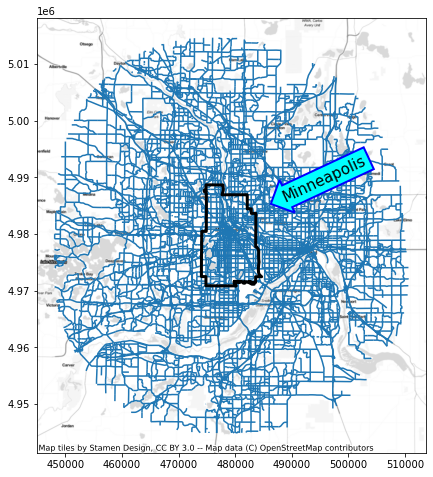

In [44]:
### Load, Clip, & Plot

if os.path.exists('Data/aadt.geojson'): # If already in directory
    
    aadt = gpd.read_file('Data/aadt.geojson')
    
    
else: # Download and clip
    
    ## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)
    
    print('Downloading AADT from GeoSpatialCommons (~5mb)')

    url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/shp_trans_aadt_traffic_segments.zip'
    extract_zip_from_url(url)
    
    ## Load and clip

    # Get path

    folder = url.split('/')[-1][:-4] # Get folder name (last part of address minus .zip)
    filename = 'Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp'
    path = folder + '/' + filename

    mn_aadt = gpd.read_file(path) # Read data to geodataframe
    
    # Clip
    
    extent = gpd.read_file('Data/study_extent.geojson') # Load Extent
    
    mn_aadt = mn_aadt.to_crs('EPSG:26915') # Get into same CRS
    
    aadt = gpd.clip(mn_aadt, extent) # Clip
    
# Show Data

# Load Minneapolis Boundary

mpls = gpd.read_file('Data/mpls_boundary.geojson')

f, ax = plt.subplots(1,1,figsize = (8,8))

aadt.plot(ax = ax)

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Annotate

for i, row in mpls.iterrows():
    
    # Get important locations
    center = row.geometry.representative_point().coords[0]
    bounds = aadt.total_bounds
    top_right = (bounds[2], bounds[3])
    text_spot = tuple(map(lambda i, j: i - j, top_right, (15000, 25000)))
    
    # Make text within an arrow
    ax.text(text_spot[0], text_spot[1], 
            row.CTU_NAME, ha="center", 
            va="center", rotation=25, size=15, 
            bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2))
    
    # ax.annotate(text=row.CTU_NAME, 
    #             xy = row.geometry.representative_point().coords[0], 
    #             xytext = text_spot, # Placement
    #             arrowprops = dict(width=.7, arrowstyle='simple')
    #             ha='center', size = 32, weight = 'bold')

contextily.add_basemap(ax = ax, 
                       crs = mpls.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

In [7]:
# Save aadt as geojson

aadt.to_file(r'Data/aadt.geojson', driver='GeoJSON') # Save geojson

/home/robb/miniconda3/envs/GeoDI/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
